In [1]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, learning_curve
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from time import clock

In [2]:
class_data = pd.read_csv("winequality-red.csv", delimiter=";")
X, y = class_data.iloc[:,:-1], class_data.iloc[:,-1]-3
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

In [3]:
pipeline = Pipeline([
    ('standardscaler', StandardScaler()),
    ('clf', KNeighborsClassifier())
])


gbm_param_grid = {
    'clf__n_neighbors':range(1,201),
    'clf__weights':['uniform', 'distance'],
    'clf__metric':['euclidean', 'manhattan', 'chebyshev', 'minkowski']
}

# Perform RandomizedSearchCV
randomized = RandomizedSearchCV(pipeline, param_distributions=gbm_param_grid, n_iter=800, cv=4, scoring='accuracy',
                                refit=True, n_jobs = -1, verbose=1, random_state=123)

# Fit the estimator
start = clock()
randomized.fit(X_train, y_train)
stop = clock()
print('Time to hypertune: {:.3f}'.format(stop-start))

Fitting 4 folds for each of 800 candidates, totalling 3200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 329 tasks      | elapsed:    8.6s
[Parallel(n_jobs=-1)]: Done 829 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 1529 tasks      | elapsed:   34.5s
[Parallel(n_jobs=-1)]: Done 2429 tasks      | elapsed:   53.0s
[Parallel(n_jobs=-1)]: Done 3189 out of 3200 | elapsed:  1.1min remaining:    0.1s


Time to hypertune: 69.273


[Parallel(n_jobs=-1)]: Done 3200 out of 3200 | elapsed:  1.2min finished
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


In [4]:
# Extract best hyperparameters from 'grid'
print('Best hyperparameters:\n', randomized.best_params_)

# Extract best CV score from 'grid'
print('Best CV accuracy: {:.3f}'.format(randomized.best_score_))

# Extract best model from 'grid'
best_model = randomized.best_estimator_

# Evaluate test set accuracy
test_acc = best_model.score(X_test, y_test)

# Print test set accuracy
print('Test set accuracy of best model: {:.3f}'.format(test_acc))

# Print CV confusion matrix
best_model.fit(X_train, y_train)
y_pred = best_model.predict(X_test)
print(confusion_matrix(y_test, y_pred))

# Mean fit and score time for best parameters
print('Mean fit time: {:.4f}'.format(randomized.cv_results_['mean_fit_time'][randomized.best_index_]))
print('Mean score time: {:.4f}'.format(randomized.cv_results_['mean_score_time'][randomized.best_index_]))

Best hyperparameters:
 {'clf__weights': 'distance', 'clf__n_neighbors': 85, 'clf__metric': 'manhattan'}
Best CV accuracy: 0.686
Test set accuracy of best model: 0.656
[[ 0  0  1  0  0  0]
 [ 0  0  8  5  0  0]
 [ 0  0 97 34  0  0]
 [ 0  0 27 97  7  0]
 [ 0  0  0 23 16  0]
 [ 0  0  0  2  3  0]]
Mean fit time: 0.0040
Mean score time: 0.0225


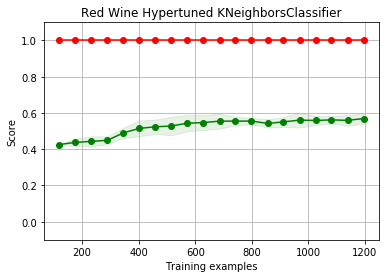

In [5]:
# Learning Curve
train_sizes, train_scores, test_scores = learning_curve(best_model, X, y, n_jobs=-1, 
                                                        cv=4, train_sizes=np.linspace(.1, 1.0, 20), verbose=0)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure()
plt.title("Red Wine Hypertuned KNeighborsClassifier")
plt.xlabel("Training examples")
plt.ylabel("Score")
plt.gca().invert_yaxis()

# box-like grid
plt.grid()

# plot the std deviation as a transparent range at each training set size
plt.fill_between(train_sizes, train_scores_mean - train_scores_std, train_scores_mean + train_scores_std, alpha=0.1, color="r")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std, test_scores_mean + test_scores_std, alpha=0.1, color="g")

# plot the average training and test score lines at each training set size
plt.plot(train_sizes, train_scores_mean, 'o-', color="r", label="Training score")
plt.plot(train_sizes, test_scores_mean, 'o-', color="g", label="Cross-validation score")

# sizes the window for readability and displays the plot
# shows error from 0 to 1.1
plt.ylim(-.1,1.1)
plt.show()